In [1]:
import pydicom
import os,re
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
from IPython.display import clear_output
import math
import sys

from ipywidgets import interact, fixed
from IPython.display import clear_output
import registration_utilities as ru
import registration_callbacks as rc

import cv2

In [2]:
p=256 #for dicom scaling
ESP=0.1 #for dicom scaling

def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    # img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z]
    fixed = sitk.GetArrayFromImage(fixed)
    moving = sitk.GetArrayFromImage(moving)
    dst = cv2.addWeighted(fixed[image_z,:,:],1.0-alpha,moving[image_z,:,:],alpha,0)
    plt.imshow(dst, cmap=plt.cm.Greys_r)
    # plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    plt.figure()
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def save_transform_and_image(transform, fixed_image, moving_image, fixed_ori,moving_ori, dicompath, outputfile_prefix,multi_tp):
    global cnt_global                       
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)    
    resample.SetInterpolator(sitk.sitkBSpline)  
    resample.SetTransform(transform)
    #sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix+'.mha')
    #sitk.WriteTransform(transform, outputfile_prefix+'.tfm')
    max_moving = 0
    min_moving = 0
    exqimg = sitk.GetArrayFromImage(resample.Execute(moving_image))
    print(exqimg.shape)
    fix_imgs =  sitk.GetArrayFromImage(fixed_image)
    for i in range(0,exqimg.shape[0]):
        max_moving = max(max_moving,np.amax(exqimg[i,:,:]))
        min_moving = min(min_moving,np.amin(exqimg[i,:,:]))
        head1,tail1 = os.path.split(fixed_ori[0])
        head2,tail2 = os.path.split(moving_ori[0])
        
        #if ('S101' in tail1) and ('S104' in tail2):
         #   Aname = Adomainpath + str(cnt_global)+'.png'
          #  Bname = Bdomainpath + str(cnt_global)+'.png'
           # plt.imsave(Aname, fix_imgs[i,:,:],cmap = plt.get_cmap('gray'))
            #plt.imsave(Bname, exqimg[i,:,:],cmap = plt.get_cmap('gray'))
            #cnt_global += 1
            #print(Aname)
        
    if multi_tp == False:

        ds_ori = pydicom.dcmread(fixed_ori[0])
        ds_ori_end = pydicom.dcmread(fixed_ori[-1])
        sp_x = (ds_ori_end[0x20,0x32].value[0]-ds_ori[0x20,0x32].value[0])/len(fixed_ori)
        sp_y = (ds_ori_end[0x20,0x32].value[1]-ds_ori[0x20,0x32].value[1])/len(fixed_ori)
        sp_z = (ds_ori_end[0x20,0x32].value[2]-ds_ori[0x20,0x32].value[2])/len(fixed_ori)
        a =  ds_ori_end.SliceLocation-float(ds_ori_end[0x20,0x32].value[0])
        b =  ds_ori_end.SliceLocation-float(ds_ori_end[0x20,0x32].value[1])
        c =  ds_ori_end.SliceLocation-float(ds_ori_end[0x20,0x32].value[2])
        spori = -math.sqrt(sp_x*sp_x+sp_y*sp_y+sp_z*sp_z)
        slicelocation_axis = 'x'
        if min(a,b,c)==b:
            slicelocation_axis = 'y'
        elif min(a,b,c)==c:
            slicelocation_axis = 'z'

        if len(moving_ori)<len(fixed_ori):
            reg_img = resample.Execute(moving_image)
            #reg_img_resample = zoom(reg_img, (1, 1, len(moving_ori)/len(fixed_ori)))

            new_x_size = (reg_img.GetSize())[0] 
            new_y_size = (reg_img.GetSize())[1]
            new_z_size = len(moving_ori) #downsample
            new_size = [new_x_size, new_y_size, new_z_size]
            new_spacing = [old_sz*old_spc/new_sz  for old_sz, old_spc, new_sz in zip(reg_img.GetSize(), reg_img.GetSpacing(), new_size)]
            interpolator_type = sitk.sitkLinear

            reg_img_resample = sitk.Resample(reg_img, new_size, sitk.Transform(),\
                                             interpolator_type, reg_img.GetOrigin(),\
                                             new_spacing, reg_img.GetDirection(), 0.0, reg_img.GetPixelIDValue())
            
            new_reg_img_resample = (reg_img_resample-min_moving)/(max_moving-min_moving)*p

            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path) 
                #new_data = ds.pixel_array
                new_data = sitk.GetArrayFromImage(new_reg_img_resample[:,:,i])
                #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                new_data[new_data<0]=0
                new_data[new_data>p]=p
                new_data = (new_data).astype('int16')
                sp = -(spori)*(len(fixed_ori)/len(moving_ori))
                xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                #print((float(ds_ori[0x18,0x88].value)),len(fixed_ori),len(moving_ori),sp)
                ds[0x18,0x88].value = sp

                ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                if slicelocation_axis == 'x':
                    ds.SliceLocation = ds_ori.SliceLocation+xsp*i
                elif slicelocation_axis == 'y':
                    ds.SliceLocation = ds_ori.SliceLocation+ysp*i
                elif slicelocation_axis == 'z':
                    ds.SliceLocation = ds_ori.SliceLocation+zsp*i
                orientation = [ds_ori[0x20,0x32].value[0]+xsp*i,\
                                ds_ori[0x20,0x32].value[1]+ysp*i,ds_ori[0x20,0x32].value[2]+zsp*i]
                ds[0x20,0x32].value =  orientation
                ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                ds.PixelData = new_data.tostring()
                newpath = dicompath+ tail
                ds.save_as(newpath)
                print(newpath)

        elif len(moving_ori)>=len(fixed_ori):    
            for i in range(0,len(moving_ori)): 
                path = moving_ori[i]
                ds = pydicom.dcmread(path)
                head,tail = os.path.split(path)
                reg_img = resample.Execute(moving_image)
                
                new_reg_img = (reg_img-min_moving)/(max_moving-min_moving)*p
                #new_reg_img = reg_img
                if i < len(fixed_ori):
                    ds_ori = pydicom.dcmread(fixed_ori[i])
                    #new_data = ds.pixel_array
                    new_data = sitk.GetArrayFromImage(new_reg_img[:,:,i])
                    #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
                    new_data[new_data<0]=0
                    new_data[new_data>p]=p
                    new_data = (new_data).astype('int16')
                    ds[0x20,0x32].value = ds_ori[0x20,0x32].value
                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    ds.SliceLocation = ds_ori.SliceLocation
                    ds[0x28,0x10].value = ds_ori[0x28,0x10].value
                    ds[0x28,0x11].value = ds_ori[0x28,0x11].value
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)
                else:
                    ds_ori = pydicom.dcmread(fixed_ori[-1])
                    new_data = np.zeros((ds_ori.Rows,ds_ori.Columns))            
                    new_data = (new_data).astype('int16')
                    sp = -(float(ds_ori[0x18,0x88].value))
                    xsp = (sp_x)*(len(fixed_ori)/len(moving_ori))
                    ysp = (sp_y)*(len(fixed_ori)/len(moving_ori))
                    zsp = (sp_z)*(len(fixed_ori)/len(moving_ori))
                    orientation = [ds_ori[0x20,0x32].value[0]+xsp*(i-len(fixed_ori)),\
                                   ds_ori[0x20,0x32].value[1]+ysp*(i-len(fixed_ori))\
                                   ,ds_ori[0x20,0x32].value[2]+zsp*(i-len(fixed_ori))]
                    ds[0x20,0x32].value =  orientation


                    ds[0x20,0x37].value = ds_ori[0x20,0x37].value
                    if slicelocation_axis == 'x':
                        ds.SliceLocation = ds_ori.SliceLocation+xsp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'y':
                        ds.SliceLocation = ds_ori.SliceLocation+ysp*(i-len(fixed_ori))
                    elif slicelocation_axis == 'z':
                        ds.SliceLocation = ds_ori.SliceLocation+zsp*(i-len(fixed_ori))
                    #ds.SliceLocation = ds_ori.SliceLocation+sp*(i-len(fixed_ori))
                    ds[0x28,0x30].value = ds_ori[0x28,0x30].value
                    ds.Rows = ds_ori.Rows
                    ds.Columns = ds_ori.Columns
                    ds.PixelData = new_data.tostring()
                    newpath = dicompath+ tail
                    ds.save_as(newpath)
                    print(newpath)


           # ds = pydicom.dcmread(newpath)
           # img = ds.pixel_array
           # plt.figure()
           # plt.imshow(img)
           # plt.show()
           # plt.close()
    else:
        reg_img = resample.Execute(moving_image)
        new_reg_img = (reg_img-min_moving)/(max_moving-min_moving)*p
        for i in range(0,len(moving_ori)): 
            path = moving_ori[i]
            ds = pydicom.dcmread(path)
            head,tail = os.path.split(path)
            ds_ori = pydicom.dcmread(fixed_ori[i])
            #new_data = ds.pixel_array
            new_data = sitk.GetArrayFromImage((new_reg_img)[:,:,i])
            #new_data = (new_data-np.amin(new_data))/(np.amax(new_data)-np.amin(new_data)+ESP)*p
            new_data[new_data<0]=0
            new_data[new_data>p]=p
            new_data = (new_data).astype('int16')
            ds[0x20,0x32].value = ds_ori[0x20,0x32].value
            ds[0x20,0x37].value = ds_ori[0x20,0x37].value
            ds.SliceLocation = ds_ori.SliceLocation
            ds[0x28,0x10].value = ds_ori[0x28,0x10].value
            ds[0x28,0x11].value = ds_ori[0x28,0x11].value
            ds[0x28,0x30].value = ds_ori[0x28,0x30].value
            ds.PixelData = new_data.tostring()
            newpath = dicompath+ tail
            ds.save_as(newpath)
            print(newpath)


# Callback we associate with the StartEvent, sets up our new data.
def metric_start_plot():
    global metric_values, multires_iterations
    global current_iteration_number
    
    metric_values = []
    multires_iterations = []
    current_iteration_number = -1

# Callback we associate with the EndEvent, do cleanup of data and figure.
def metric_end_plot():
    global metric_values, multires_iterations
    global current_iteration_number

    del metric_values
    del multires_iterations
    del current_iteration_number
    # Close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

# Callback we associate with the IterationEvent, update our data and display 
# new figure.    
def metric_plot_values(registration_method):
    global metric_values, multires_iterations
    global current_iteration_number
    
    # Some optimizers report an iteration event for function evaluations and not
    # a complete iteration, we only want to update every iteration.
    if registration_method.GetOptimizerIteration() == current_iteration_number:
        return

    current_iteration_number =  registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot 
    # current data.
    clear_output(wait=True)
    # Plot the similarity metric values.
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback we associate with the MultiResolutionIterationEvent, update the 
# index into the metric_values list. 
def metric_update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

def sortdir(flist):
    for file in flist:
        if ('.dcm') not in file:
            del flist[flist.index(file)]
        for j in range(0,len(flist)):
            for k in range(j+1,len(flist)):
                num=int(re.split('E|S|I|.dcm',flist[j])[3])
                num2=int(re.split('E|S|I|.dcm',flist[k])[3])
                if num>num2:
                    tmp=flist[j]
                    flist[j]=flist[k]
                    flist[k]=tmp
    return flist

print('Functions successfully defined.')

Functions successfully defined.


In [3]:
# return numpy images && sitk images
def read_dicom_image(file_path):
    reader = sitk.ImageSeriesReader()
    series_Names = reader.GetGDCMSeriesFileNames(file_path)
    print(len(series_Names))
    reader.SetFileNames(series_Names)
    image3D = reader.Execute()
    print('size =', image3D.GetSize()) #width(x), height(y), depth(z) 
    resacleFilter = sitk.RescaleIntensityImageFilter()
    resacleFilter.SetOutputMaximum(255)
    resacleFilter.SetOutputMinimum(0)
    image3D = resacleFilter.Execute(image3D)
#     origin = image3D.GetOrigin() # x, y, z
#     spacing = image3D.GetSpacing() # x, y, z
#     sitk.WriteImage(image3D, 'img3D.dcm')
    img_array = sitk.GetArrayFromImage(image3D) # z, y, x
    img_array = np.transpose(img_array,(2,1,0)) 
    return img_array, image3D

In [43]:
# save sitk images
def write_dicom_image(img_series, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for z in range(img_series.GetDepth()):
        img = img_series[:,:,z]
        sitk.WriteImage(img,save_path+"/%03d.dcm" % (z+1))

In [67]:
# The first image should not be Coronal plane 整个文件夹里只应该有横断面的数据!!!
file_path = "./data/9404954L/TP3"
img_array, fixed_image = read_dicom_image(file_path)
file_path = "./data/9404954L/TP10"
img_array, moving_image = read_dicom_image(file_path)
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

75
size = (384, 384, 75)
75
size = (384, 384, 75)


interactive(children=(IntSlider(value=37, description='fixed_image_z', max=74), IntSlider(value=37, descriptio…

In [58]:
file_path = "./data/9404954L/TP6"
img_array, moving_image = read_dicom_image(file_path)

75
size = (384, 384, 75)


In [69]:
img1 = fixed_image
img2 = moving_image

In [6]:
def do_thresh(images):
    new_images = []
    for z in range(images.GetDepth()):
        img = sitk.GetArrayFromImage(images[:,:,z])
        img = img.astype(np.uint8)
        th1, binary1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         th2, binary2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
#         binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 10)
        
        new_images.append(binary1)
    img_array = np.array(new_images)

    return sitk.GetImageFromArray(img_array)
    

In [68]:
fixed_image = do_thresh(img1)
moving_image = do_thresh(img2)
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=37, description='fixed_image_z', max=74), IntSlider(value=37, descriptio…

In [8]:
def preprocess(images):
    new_images = []
    for z in range(images.GetDepth()):
        img = sitk.GetArrayFromImage(images[:,:,z])
        img = img.astype(np.uint8)
        dst = cv2.equalizeHist(img)
        size = 3
        kernel = np.ones((size, size), dtype=np.uint8)
        img_erosion = cv2.erode(dst, kernel, iterations=1)
        img_dilation = cv2.dilate(dst, kernel, iterations=1)
        img_open = cv2.dilate(cv2.erode(dst, kernel), kernel)
        new_images.append(dst)
    img_array = np.array(new_images)

    return sitk.GetImageFromArray(img_array)

In [9]:
def edge_detect(images, threshold2=100):
    new_images = []
    for z in range(images.GetDepth()):
        img = sitk.GetArrayFromImage(images[:,:,z])
        img = img.astype(np.uint8)
        
        img = cv2.GaussianBlur(img,(5,5),0)
        canny = cv2.Canny(img, 50, threshold2, apertureSize = 3) # threshold2越大，提取的边缘越少
        
        new_images.append(canny)
    img_array = np.array(new_images)

    return sitk.GetImageFromArray(img_array)

In [8]:
fixed_image = edge_detect(img1, 150)
moving_image = edge_detect(img2, 100)
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=37, description='fixed_image_z', max=74), IntSlider(value=37, descriptio…

In [10]:
# initial transform
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

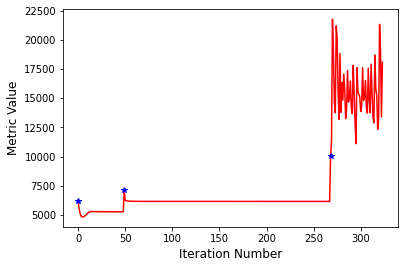

Final metric value: 15556.847034366476
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 56.


In [13]:
# rigid registration
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=500)
# registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
# registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetMetricAsMeanSquares()

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-10, convergenceWindowSize=50)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [14]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [15]:
# FFD transform(Free Form Deformation)
def bspline_intra_modal_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [10.0, 10.0, 10.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    
    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    else:
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
    
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

def generate_random_pointset(image, image2, num_points):
    """
    Generate a random set (uniform sample) of points in the given image's domain.
    
    Args:
        image (SimpleITK.Image): Domain in which points are created.
        num_points (int): Number of points to generate.
        
    Returns:
        A list of points (tuples).
    """
    # Continous random uniform point indexes inside the image bounds.
    point_indexes = np.multiply(np.tile(image.GetSize(), (num_points, 1)), 
                                np.random.random((num_points, image.GetDimension())))
    pointset_list = point_indexes.tolist()
    # Get the list of physical points corresponding to the indexes.
    return [image.TransformContinuousIndexToPhysicalPoint(point_index) \
            for point_index in pointset_list], [image2.TransformContinuousIndexToPhysicalPoint(point_index) \
            for point_index in pointset_list]

In [66]:
def bspline_intra_modal_registration2(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we 
    # want for the finest resolution control grid. 
    grid_physical_spacing = [10.0, 10.0, 10.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    # The starting mesh size will be 1/4 of the original, it will be refined by 
    # the multi-resolution framework.
    mesh_size = [int(sz/4 + 0.5) for sz in mesh_size]
    
    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    # Instead of the standard SetInitialTransform we use the BSpline specific method which also
    # accepts the scaleFactors parameter to refine the BSpline mesh. In this case we start with 
    # the given mesh_size at the highest pyramid level then we double it in the next lower level and
    # in the full resolution image we use a mesh that is four times the original size.
    registration_method.SetInitialTransformAsBSpline(initial_transform,
                                                     inPlace=True,
                                                     scaleFactors=[1,2,4])
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    # Use the LBFGS2 instead of LBFGS. The latter cannot adapt to the changing control grid resolution.
    registration_method.SetOptimizerAsLBFGS2(solutionAccuracy=1e-5, numberOfIterations=100, deltaConvergenceTolerance=0.01)

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    else:
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
     
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

In [21]:
# fixed_points, moving_points = generate_random_pointset(fixed_image, moving_image, 100)

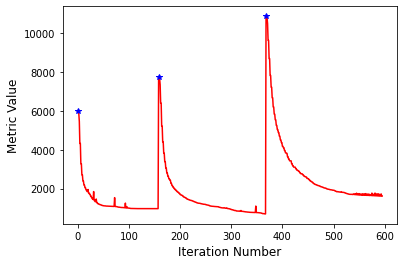

Final metric value: 1618.4103029474911
Optimizer's stopping condition, LBFGSBOptimizerv4: User requested


In [17]:
ffd_transform = bspline_intra_modal_registration(fixed_image = fixed_image, 
                                    moving_image = moving_image,
#                                     fixed_points=fixed_points, 
#                                     moving_points=moving_points
                                    )
# 上面取消注释会报错module 'SimpleITK' has no attribute 'CompositeTransform'，但文档里c++版本是有这个类的

In [47]:
moving_resampled = sitk.Resample(moving_image, fixed_image, ffd_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [42]:
write_dicom_image(moving_resampled, "./data/9404954L/TPtest")

In [64]:
def test_preprocess(images):
    new_images = []
    for z in range(images.GetDepth()):
        img = sitk.GetArrayFromImage(images[:,:,z])
        img = img.astype(np.uint8)
#         th2, binary2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
#         binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 10)
        
        new_images.append(img)
    img_array = np.array(new_images)

    return sitk.GetImageFromArray(img_array)

In [65]:
moving_image = test_preprocess(img2)
fixed_image = test_preprocess(img1)
moving_resampled = sitk.Resample(moving_image, fixed_image, ffd_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

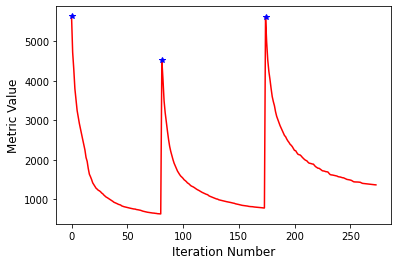

Final metric value: 1364.8470368659468
Optimizer's stopping condition, Reached maximum number of iterations


In [70]:
ffd_transform2 = bspline_intra_modal_registration2(fixed_image = fixed_image, 
                                    moving_image = moving_image,
#                                     fixed_points=fixed_points, 
#                                     moving_points=moving_points
                                    )
# 上面取消注释会报错module 'SimpleITK' has no attribute 'CompositeTransform'，但文档里c++版本是有这个类的

In [71]:
moving_resampled = sitk.Resample(moving_image, fixed_image, ffd_transform2, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

Initial alignment errors in millimeters, mean(std): 11.07(0.06), max: 11.24
Final alignment errors in millimeters, mean(std): 5.77(1.94), max: 10.68


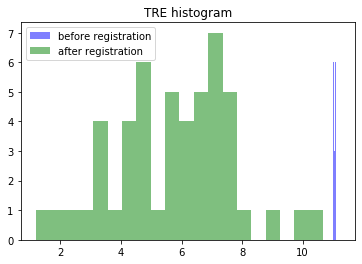

In [38]:
initial_errors_mean, initial_errors_std, _, initial_errors_max, initial_errors = ru.registration_errors(sitk.Euler3DTransform(),fixed_points, moving_points)
final_errors_mean, final_errors_std, _, final_errors_max, final_errors = ru.registration_errors(ffd_transform, fixed_points, moving_points)

plt.hist(initial_errors, bins=20, alpha=0.5, label='before registration', color='blue')
plt.hist(final_errors, bins=20, alpha=0.5, label='after registration', color='green')
plt.legend()
plt.title('TRE histogram');
print('Initial alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))
print('Final alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))

In [11]:
# DEMONS
def demons_registration(fixed_image, moving_image, fixed_points = None, moving_points = None):
    registration_method = sitk.ImageRegistrationMethod()

    # Create initial identity transformation.
    transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
    initial_transform = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform()))
    
    # Regularization (update field - viscous, total field - elastic).
    initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0) 
    
    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsDemons(10) #intensities are equal if the difference is less than 10HU
        
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,0])    

    registration_method.SetInterpolator(sitk.sitkLinear)
    # If you have time, run this code as is, otherwise switch to the gradient descent optimizer    
    #registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)        
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform  

In [12]:
demons_transform = demons_registration(fixed_image = fixed_image, 
                                    moving_image = moving_image,
                                    )

Final metric value: 758.420930757523
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (20) exceeded.


In [13]:
moving_resampled = sitk.Resample(moving_image, fixed_image, demons_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [ ]:
#############################################################################
# END
############################################################################